In [1]:
#!pip3 install transform
#!pip3 install torchvision
#!pip3 install torch==1.9.1 torchvision==0.10.1
#!pip3 install cython
#!pip3 install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'


In [31]:
#%%shell
# Download TorchVision repo to use some files from
# references/detection
#git clone https://github.com/pytorch/vision.git
#cd vision
#git checkout v0.8.2

#cp references/detection/utils.py ../
#cp references/detection/transforms.py ../
#cp references/detection/coco_eval.py ../
#cp references/detection/engine.py ../
#cp references/detection/coco_utils.py ../

In [ ]:
import os
import numpy as np
import torch
from PIL import Image
import json
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from engine import train_one_epoch, evaluate
import random
import utils 
import torchvision.transforms as T
import matplotlib.pyplot as plt
from skimage import draw
import skimage.io

In [14]:
import numpy as np

x = np.ndarray((10,32,32))
x = np.stack(x, axis=2)
x.shape

(32, 32, 10)

In [4]:
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [5]:
COLAB = False

In [6]:
SEED = 9246

np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

CUDA = torch.cuda.is_available()
device = torch.device("cuda" if CUDA else "cpu")

In [7]:
#root = "../../../dataset/elettrocablaggi_20200921/GRETA_230V"
root = "./dataset"
BATCH_SIZE = 2

# Utility Functions

In [28]:
def showImage(x,denormalize=True):
    x = x.permute((1,2,0))
    if denormalize:
      mean = torch.as_tensor([0.485, 0.456, 0.406])
      std = torch.as_tensor([0.229, 0.224, 0.225])
      x = std * x + mean
      x = torch.clip(x,0,1)
    plt.figure()
    plt.imshow(x)
    plt.show()

def showFrames(frames):
    plt.figure(figsize=(5,5))
    
    for k,x in enumerate(frames):
        plt.subplot(6,len(frames)//6+1,k+1)
        plt.axis('off')
        #x = x.permute((1,2,0))
        #x = np.clip(x,0,1)
        plt.imshow(x)
    
    plt.show()

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Load Data

In [ ]:
if not os.path.isdir("dataset"):
    if COLAB:
        !gdown --id 1XLzviOPmdWttBbSeIxTocZ6GkOH2Fvtp
        !unzip dataset.zip
    
print("Dataset ready")

In [10]:
torchvision.io.decode_jpeg

<function torchvision.io.image.decode_jpeg>

In [11]:
class ElettrocablaggiDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "images"))))[::-1]
        self.label_file = "labels.txt"
        self.annots = list(sorted(os.listdir(os.path.join(root, "annots"))))[::-1]
        self.annots.remove(self.label_file)
        
        self.class_labels = []
        self.loadClassLabels()
        
    def loadClassLabels(self):
        label_path = os.path.join(self.root, "annots", self.label_file) 
        with open(label_path, encoding='utf-8') as f:
            for line in f:
                stripped_line = line.strip()
                self.class_labels.append(int(stripped_line))
        
    def __getitem__(self, idx):
        # load images, masks, annots
        img_path = os.path.join(self.root, "images", self.imgs[idx])
        annot_path = os.path.join(self.root, "annots", self.annots[idx])
        
        #img = torchvision.io.read_image(img_path).float()/255
        
        img = skimage.io.imread(img_path)
        img = np.array(img,dtype=np.float32)/255

        img = torch.from_numpy(img).permute(2,0,1)
        
        with open(annot_path,encoding='utf-8') as f:
            data = json.load(f) 
        
        labels = []
        
        masks = torch.zeros(((len(data["regions"]),img.shape[1], img.shape[2])),dtype=torch.uint8)
        
        for i,region in enumerate(data["regions"]):
            class_name = region['tags'][0]
          
            labels.append(int(class_name))

            all_x = [a['x'] for a in region['points']]
            all_y = [a['y'] for a in region['points']]
            rr, cc = draw.polygon(all_x, all_y)            
            
            masks[i,cc, rr] = 1
            
        
        labels = torch.as_tensor(labels,dtype=torch.int64)
        num_objs = len(labels)
        image_id = torch.tensor([idx])
        
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)
        
        if self.transforms is not None:
            img,masks = self.apply_transforms(img,masks)
            
        masks = masks.bool()

        boxes = []
        for i in range(masks.shape[0]):
            mask = masks[i,:,:]
            tmp = torch.where(mask)
            all_x = tmp[0]
            all_y = tmp[1]
            boxes.append([torch.min(all_x), torch.min(all_y), torch.max(all_x), torch.max(all_y)])
        
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["iscrowd"] = iscrowd
        target["area"] = area
        

        return img, target
        
    def apply_transforms(self, img, masks,normalize=True):
        #union img and mask to apply same transformations
        transformed = torch.cat([img,masks],axis=0)
        transformed = self.transforms(transformed)
        #separate
        img,masks = transformed[:img.shape[0],:,:],transformed[img.shape[0]:,:,:]

        norm = T.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
        return norm(img),masks

    def __len__(self):
        return len(self.imgs)

In [12]:
def get_transform2(train):
    transforms = []
    transforms.append(T.ToTensor())
    transforms.append(T.Resize((320,320)))
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

def get_transform(train, device):
    transforms = torch.nn.Sequential()
    transforms.append(T.Resize((320,320)))
    if train:
        transforms.append(T.GaussianBlur(3,sigma=(0.1, 2.0)))
        transforms.append(T.RandomPerspective(distortion_scale=0.2))
        transforms.append(T.RandomHorizontalFlip(0.5))
  
    return transforms.to(device)


In [29]:
train_dataset = ElettrocablaggiDataset(os.path.join(root,"train"),get_transform(True,device))
test_dataset = ElettrocablaggiDataset(os.path.join(root,"test"),get_transform(False,device))


trainingDataLoader = torch.utils.data.DataLoader(train_dataset, 
                                                 batch_size=BATCH_SIZE, 
                                                 shuffle=True,
                                                 collate_fn=utils.collate_fn)

testDataLoader = torch.utils.data.DataLoader(test_dataset, 
                                                 batch_size=BATCH_SIZE, 
                                                 shuffle=False,
                                                 collate_fn=utils.collate_fn)

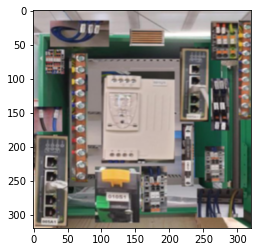

tensor([10,  5,  4, 12,  9, 10,  9, 11,  3,  5,  7,  8,  2])


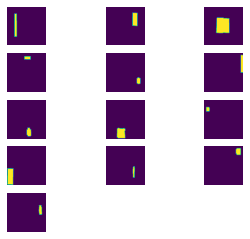

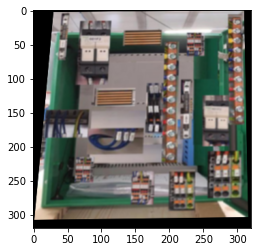

tensor([12,  8, 12,  3,  3, 10,  7,  2,  1,  1,  3, 10,  8,  7])


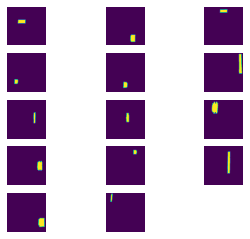

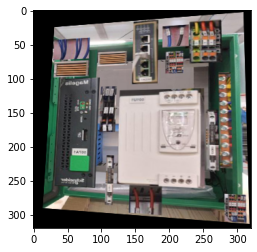

tensor([10,  7,  6,  4,  8,  5,  3, 12, 12,  3,  7,  2])


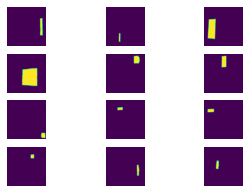

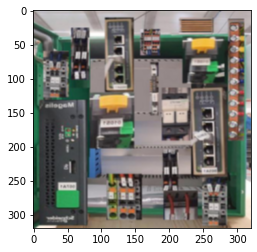

tensor([11,  7,  2, 11,  9,  5,  2,  3,  6,  8,  5,  9, 12, 10,  1])


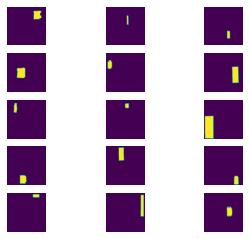

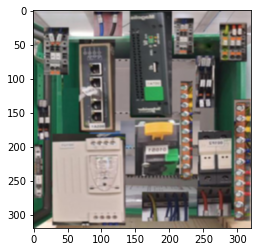

tensor([ 5, 11,  6,  4,  2,  9, 10,  2,  8,  7,  9, 10])


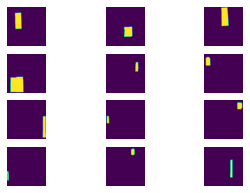

In [30]:
cont = 0
for x,y in train_dataset:
  masks = y['masks']
  frames = [] 
  for i in range(0,masks.shape[0]):
    frames.append(masks[i,:,:])

  showImage(x)
  print(y['labels'])

  showFrames(frames)
  #print(y["boxes"])
  cont+=1
  if cont == 5:
    break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


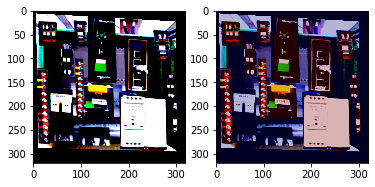

In [16]:
#x2 = T.RandomRotation(degrees=(-90,-90))(x)

plt.figure()
plt.subplot(1,2,1)
plt.imshow(x.permute(1,2,0), 'gray', interpolation='none')
plt.subplot(1,2,2)
plt.imshow(x.permute(1,2,0), 'gray', interpolation='none')
mask = np.zeros((320,320))
for i in range(masks.shape[0]):
  mask[np.where(masks[i])] = 1

plt.imshow(mask, 'jet', interpolation='none', alpha=0.3)
plt.show()

# Finetuning from a pretrained model

In [17]:
def get_model_instance_segmentation_resnet101(num_classes,freeze_backbone=False):

    # load a pre-trained model for classification and return
    # only the features
    backbone = torch.nn.Sequential(*(list(torchvision.models.resnet101().children())[:-2]))
    # FasterRCNN needs to know the number of
    # output channels in a backbone
    backbone.out_channels = 2048


    if freeze_backbone:
      for param in backbone.parameters():
        param.requires_grad = False

    # let's make the RPN generate 5 x 3 anchors per spatial
    # location, with 5 different sizes and 3 different aspect
    # ratios. We have a Tuple[Tuple[int]] because each feature
    # map could potentially have different sizes and
    # aspect ratios
    anchor_generator = AnchorGenerator(sizes=((32, 64, 128, 256, 512),),
                                      aspect_ratios=((0.5, 1.0, 2.0),))

    # let's define what are the feature maps that we will
    # use to perform the region of interest cropping, as well as
    # the size of the crop after rescaling.
    # if your backbone returns a Tensor, featmap_names is expected to
    # be [0]. More generally, the backbone should return an
    # OrderedDict[Tensor], and in featmap_names you can choose which
    # feature maps to use.
    roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=['0'],
                                                    output_size=7,
                                                    sampling_ratio=2)

    # put the pieces together inside a FasterRCNN model
    model = FasterRCNN(backbone,
                      num_classes=num_classes,
                      rpn_anchor_generator=anchor_generator,
                      box_roi_pool=roi_pooler)
    return model

In [18]:
def get_model_instance_segmentation_resnet50(num_classes,trainable_backbone_layers = 5):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True,trainable_backbone_layers = trainable_backbone_layers)

    #if freeze_backbone:
    #  for param in model.parameters():
    #    param.requires_grad = False

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

In [20]:
print(len(train_dataset.class_labels))
model = get_model_instance_segmentation_resnet50(len(train_dataset.class_labels),trainable_backbone_layers=0)

count_parameters(model)
# move model to the right device
#model.to(device)

13


Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth


  0%|          | 0.00/170M [00:00<?, ?B/s]

20526685

In [24]:
model.to(device)

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(in

In [48]:
# For Training
#images,targets = next(iter(trainingDataLoader))
#images = list(image for image in images)
#targets = [{k: v for k, v in t.items()} for t in targets]
#print(targets)
#output = model(images,targets)   # Returns losses and detections
# For inference
#model.eval()
#x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]
#predictions = model(x)           # Returns predictions

In [56]:
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)
# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

# let's train it for 10 epochs
num_epochs = 1

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, trainingDataLoader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    #evaluate(model, data_loader_test, device=device)

print("That's it!")

Epoch: [0]  [   0/5000]  eta: 4:40:12  lr: 0.000010  loss: 3.6032 (3.6032)  loss_classifier: 2.5370 (2.5370)  loss_box_reg: 0.1411 (0.1411)  loss_objectness: 0.6993 (0.6993)  loss_rpn_box_reg: 0.2258 (0.2258)  time: 3.3626  data: 0.4055  max mem: 10773
Epoch: [0]  [  10/5000]  eta: 4:28:51  lr: 0.000060  loss: 3.3621 (3.2166)  loss_classifier: 2.3259 (2.1525)  loss_box_reg: 0.1223 (0.1294)  loss_objectness: 0.7009 (0.7006)  loss_rpn_box_reg: 0.2258 (0.2341)  time: 3.2328  data: 0.2889  max mem: 10773


KeyboardInterrupt: ignored